Tianyuan Cai

# Overview

The goal of this project is to generate sensible captions for images. Image captioning has a large variety of applications. By understanding common objects in an image and transforming them into textual information, we can compress large photographic information into more compact data formats. The possibility of this type of transformation makes it easier to make inferences based on photographic data and gives rise to applications such as voice over technologies, recommender engine, etc.

In this project, I use the Inception-V3 and GloVe implementations to transform images and words into feature vectors. I then pass these data through LSTM hidden layer and produce sensible captions using word-by-word predictions. The training and validation data come from Common Objects in Context (COCO) dataset produced by Microsoft.

# Preparing Environment

I used Anaconda with Python 3.7 run on an Ubuntu 18.04 system to train and test this model. An Nvidia Titan Xp GPU was used to train the model, and 32 GB of RAM was available during training. The final data take up around 20 GB. All data are downloaded and extracted within the Jupyter Notebook, so the submission only requires the Jupyter Notebook itself to run. It helps, however, to run the notebook in an empty project folder to ensure the required data can be unpacked smoothly in the folder. 

Despite the availability of relatively powerful graphic card, I still made use of methods such as the tqdm package, data generator class of Python, and fit generator function from Keras to accommodate systems that are less powerful. Batch size, number of training images and captions, sentence length, etc. can all be adjusted to accommodate a system of lower configuration. The notebook is tested on both remote Ubuntu server and Google Colab to make sure there is no error when running. Here are some system preparations needed before starting to run the Jupyter Notebook. 

* Make sure there are at least 40 GB of disk space and sufficient memory available before running the code. 
* Install TensorFlow GPU in Anaconda by running the following command. It will install the package as well as all dependencies, such as Cuda and cuDNN.
conda install -c anaconda tensorflow-gpu
* After installing TensorFlow, use pip to install the following packages. pycocotools is dependent on Cython. Therefore, Cython must be installed first. 
    - `pip install pillow numpy matplotlibpydotpylabscikit-image keras Cython pycocotools nltk seaborntqdm`
* Data set used by this code will all be downloaded to the project folder. Change the line `data_dir = "/home/tcai/Documents/nlp/final_project"` to your own project folder. For instance, if you are using Google Colab to run this code, you can change this line to `data_dir = "/content"`. 
* Once the packages are installed and the data directory updated. Running the notebook does not require any additional setup. All the data will download into the project folder, and the model will be saved by epoch as it trains with appropriate names created for them.  


In [1]:
# # Install packages
# !pip3 install pillow numpy scikit-image keras nltk seaborn
# !pip3 install Cython
# !pip3 install pycocotools

# # If there's error in pycocotools installation, try installing directly from the repo
# !pip3 install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [1]:
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/tcai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tcai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/tcai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import packages and configure
import os
import pickle
from time import time
import json
import re

import sklearn
import keras
import pydot
from PIL import Image
import skimage.io as io
import seaborn as sns

from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
import keras.applications.imagenet_utils
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
import pylab
pylab.rcParams['figure.figsize'] = (4, 6)
from keras.applications.inception_v3 import preprocess_input

# The kernal occasionally dies on Google Colab when installing and importing pycocotools at the same time
# It's good to install the pycocotools first, and run the import code in a separate session
from pycocotools.coco import COCO

Using TensorFlow backend.


In [3]:
# Test if running on GPU
keras.backend.tensorflow_backend._get_available_gpus()

W0803 18:25:20.267357 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 18:25:20.268951 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0803 18:25:20.270853 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0803 18:25:20.478276 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. P

['/job:localhost/replica:0/task:0/device:GPU:0']

# Data

## Data Overview

Three data sets are downloaded and unpacked as the code runs:
* Training image data set from Common Objects in Context (COCO) data set  produced by Microsoft. Due to the size of this data set, I obtain a subset of the downloaded data set and split it into train and validation set.
* Captions of the training images from COCO . This data set contain captions that correspond to the images in the training images data set.

The COCO dataset provides a set of images of common objects in their natural context. The images are collected from a variety of sources, and the corresponding caption data provide multiple short captions to each image. The captions describe the objects in and the context of the image. Furthermore, the COCO API can be used to categorized by their super-categories, such as animal, furniture, sports, etc. for easy access. Here is an example of an image from the COCO data together with its corresponding captions.

See [Coco API](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) for package usage. 

We start by extracting image and caption (annotation) data from COCO website. 

In [4]:
# Specify data directory and the COCO training file to be used
data_dir = "/home/tcai/Documents/nlp/final_project"
data_type = "train2017"
data_zipfile = '%s.zip' % (data_type)

Run the following command only once to obtain and extract files. If the files already exist, remove them to ensure the `get_file` commands can run smoothly.

In [6]:
# Download annotation, image, and glove
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                         cache_subdir=os.path.abspath('.'),
                                         origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                         extract = True)
image_zip = tf.keras.utils.get_file(data_zipfile,
                                    cache_subdir=os.path.abspath('.'),
                                    origin = 'http://images.cocodataset.org/zips/%s'%(data_zipfile),
                                    extract = True)
glove6b_zip = tf.keras.utils.get_file('glove.6B.zip',
                                    cache_subdir=os.path.abspath('./glove6b'),
                                    origin = 'http://nlp.stanford.edu/data/glove.6B.zip',
                                    extract = True)

In [5]:
# Update file directory objects
annotation_file = data_dir + '/annotations/captions_%s.json' % (data_type)
image_dir = data_dir + '/%s/' % (data_type)

Coco provides images that are categorized into a variety of categories. The categories listed below can be used to index images in the data set.

In [6]:
# Initialize COCO api to show sample images and match images with captions
coco_caps = COCO(annotation_file)

# Obtain categories
annFile = '{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco = COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('\nCOCO Categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO Supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=11.18s)
creating index...
index created!

COCO Categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO Supercategories: 
kitchen electronic food vehicle indoor animal sports person furniture appliance accessory outdoor


COCO API has a handy feature that allows the user to see images by custom categories. For instance, when inputing the feature `['dog','person', 'ball']`, here is what the model shows.

The index of the chosen image is 106484.

The corresponding captions are:
A man walking a dalmatian on a red leash.
The man has a red leash on his Dalmatian dog.
a man walks a dog with a leech 
A guy is walking his dalmatian down the road. 
A man walking a dalmatian on leash in front of a firetruck.


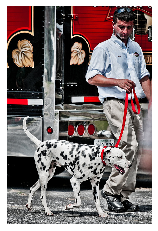

In [7]:
# Show sample data set by choosing categories
temp_cat = ['dog', 'person', 'ball']

catIds = coco.getCatIds(catNms=temp_cat)
imgIds = coco.getImgIds(catIds=catIds)

# Identify relevant images
if len(imgIds) > 0:
    imgIds = coco.getImgIds(imgIds=imgIds[-1])  # Pick the last image
    print("The index of the chosen image is %s.\n" % (str(imgIds[0])))
else:
    print("No matched images found.")

# Load and display captions
annIds = coco_caps.getAnnIds(imgIds)
anns = coco_caps.loadAnns(annIds)
print("The corresponding captions are:")
coco_caps.showAnns(anns)

# Show image
img = coco.loadImgs(imgIds)[0]
I = io.imread('%s/%s/%s' % (data_dir, data_type, img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

The concise captions provide several layers of information including the objects, their relationships, and the context or the background of the image, each with some variety. For instance, note that in the image above, the person is said to be “a man”, “a guy”, and “the man”; The dog is said to be “Dalmatian dog”, “dalmatian”, and “a dog”. Furthermore, the captions identify the relationship between the objects shown – the man is said to have a leash on his dog or walking the dog; the ownership of the dog is sometimes identified as well. Furthermore, relationship between the objects and the context is also accurately reflected – the man and the dog are walking “in front of a firetruck”. 

However, the captions have their idiosyncrasies beyond semantic meanings. One caption has the first letter in lowercase, and others do not. One caption capitalized the first letter in “Dalmatian” while others do not. When processing the caption data, I transformed all words and removed special characters to ensure the captions are consistent. Similarly, the images in the data set also have inconsistent qualities. Therefore, additional preprocessing is performed on the images, such as converting images to 299 by 299 dimension before encoding them with the Inception V3 model.

When preparing the dataset, the captions, images paths, and encoded image features are all needed in order to effectively implemented the training. Rather than using train_test_split function, I choose to shuffle the data and subset to the desired number of train and test samples. Related data of each category share the same index throughout the analysis.
Again, note that the data set used by this code will all be created in the project folder. Look for the line `data_dir = “/home/tcai/Documents/nlp/final_project”` and change this directory into yours. Once the data set is downloaded and the images shuffled, I moved on to create image and text embeddings. 

## Train-test Split

Captions, images paths, and encoded image features are needed in order to effectively implemented the training. Rather than using `train_test_split` function, I choose to shuffle the data and subset to obtain a 80/20 split of train and validation data.

In [8]:
# Specify total number of samples to be used for training and testing.
total_examples = 100000
train_examples = int(0.8 * total_examples)

# Subset training and testing images
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_img_path_vector = {}
all_img_name_vector = list(set([x['image_id'] for x in annotations['annotations']]))
print(
    "Choosing %s training images and %s validation images from a total of %s images"
    % (train_examples, total_examples - train_examples, len(all_img_name_vector)))

for img_id in all_img_name_vector:
    img = coco.loadImgs(img_id)[0]
    image_file_path = '%s/%s/%s' % (data_dir, data_type, img['file_name'])
    all_img_path_vector[img_id] = image_file_path

# Shuffle and obtain subset
all_img_name_vector = sklearn.utils.shuffle(all_img_name_vector, random_state=0)
all_img_name_vector = all_img_name_vector[:total_examples]

# Obtain train and test set
train_img_name_vector = all_img_name_vector[:train_examples]  # train
test_img_name_vector = all_img_name_vector[train_examples:]  # test

Choosing 80000 training images and 20000 validation images from a total of 118287 images


# Image Embeddings

I use the Inception V3 model as an image encoder by removing the fully connected layers in the end. The lower dimensional representation of the images reduces the amount of data needed by the model to perform prediction of the captions. In addition, since the Inception V3 model is built to minimize the loss function for accurate object recognition, using the model as an encoder helps minimize this loss function for the training image data I used. 

In [9]:
# Create the inception v3 model
# take out the fully connected layers at the end to have it output image embeddings
image_model = keras.applications.InceptionV3(weights='imagenet')
feature_model = keras.models.Model(image_model.input,
                                   image_model.layers[-2].output)

W0803 18:25:38.613325 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 18:25:38.632505 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0803 18:25:38.790925 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 18:25:40.249949 140642564364096 deprecation_wrapper.py:119] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is depr

Define encoding function that:
* Transform the image into consistent sizes
* Convert the images to array
* Expand dimensions
* Pre-process the input
* Reshape images

In [10]:
# Encoding function for feature extraction
def encode(image_path):
    # Preprocess images
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    
    # Produce image embeddings
    fea_vec = feature_model.predict(img_array)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return (fea_vec)

Define a similar function but for showcasing Inception V3's prediction ability.

In [11]:
# Similar function for testing how inception v3 model works
def inceptionv3_predict(image_path, image_model):
    # Preprocess images
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    preds = image_model.predict(img_array)
    P = keras.applications.imagenet_utils.decode_predictions(preds)

    # Show prediction result
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

    # Show image
    I = io.imread(image_path)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Below is an example of the prediction produced by the original Inception V3 model. The model outputs a score for each observed item, reflecting its confidence in the prediction.

1. freight_car: 40.83%
2. passenger_car: 29.35%
3. electric_locomotive: 5.97%
4. steam_locomotive: 1.17%
5. mobile_home: 0.59%


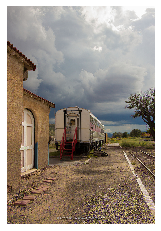

In [12]:
# Randomly choose images to be predicted by Inception V3
random_img_id = np.random.choice(all_img_name_vector)
random_img_path = all_img_path_vector[random_img_id]
inceptionv3_predict(random_img_path, image_model)

To encode the image using Inception V3, I first transform images into 299 by 299 dimension, convert them to arrays, and then use the preprocessing function in Keras to preprocess the images. I then transfer the weight learned by Inception V3 on ImageNet data onto predicting the training data set. The output of the predict function is the encoded image features, and I store the output in a pickle file, indexed by image IDs so that I can use them for future uses. The 100,000 images in the training and validation data set took around 2,100 seconds to encode. The composition of the final data set is as follows:

* Training: 80,000 distinct images, 400204 captions.
* Validation: 20,000 distinct images, 100057 captions.

Note that because each image is paired with multiple captions, the number of captions is larger than that of the images. When training images, I choose distinct images to ensure the same image is not encoded multiple times. 


In [15]:
# Encode all the train images. Run once and store features in a pickle file
start = time()
train_features = {}
for img_id in all_img_name_vector:
    train_features[img_id] = encode(all_img_path_vector[img_id])

# Took around 2100 seconds.
print("Time taken in seconds =", time() - start)

# Pickle the features
with open(data_dir + "/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(train_features, encoded_pickle)

In [13]:
# Load image features from the pickle file
train_features = pickle.load(open(data_dir + "/encoded_train_images.pkl", "rb"))
print('%d photos in total are encoded. These include both training and testing image set.' 
      % len(train_features))

100000 photos in total are encoded. These include both training and testing image set.


For each captions in the training and testing data set, I append images back onto the captions so that all captions and features are included.

In [14]:
# Create the train image data set
captions = []
images = []
images_features = []

for img_id in train_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))

    for caption in [x['caption'] for x in img_captions]:
        captions.append('start_sentence ' + caption + ' end_sentence')
        images.append(img_path)
        images_features.append(img_feature)

captions, images, images_features = sklearn.utils.shuffle(captions,
                                                          images,
                                                          images_features,
                                                          random_state=0)

In [15]:
# Create the validation image data set
test_captions = []
test_images = []
test_images_features = []

for img_id in test_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))

    for caption in [x['caption'] for x in img_captions]:
        test_captions.append('start_sentence ' + caption + ' end_sentence')
        test_images.append(img_path)
        test_images_features.append(img_feature)

test_captions, test_images, test_images_features = sklearn.utils.shuffle(
    test_captions, test_images, test_images_features, random_state=0)

In [16]:
print('Training: %s distinct images, %s captions,' %
      (len(list(set(images))), len(captions)))
print('Validation: %s distinct images, %s captions.' %
      (len(list(set(test_images))), len(test_captions)))

Training: 80000 distinct images, 400204 captions,
Validation: 20000 distinct images, 100057 captions.


# Word Embeddings

Before using the captions in the training and prediction, the data are first processed to remove special characters and tokenized. Later on, as the sentence is separated by words and supplied to the model word-by-word as training and validation, the sentence is then padded to the maximum length. In addition, sentence starting tag “start_sentence” and ending tag “end_sentence” are added to the tokenizer and the training captions to help identify the end of a caption.

After removing special characters and tokenize the words, the lengths of the sentences have the following distribution. I limit the maximum sentence length to 100, and the maximum number of words to 6,000. When setting the maximum sentence length, I referred to the sentence length distribution as follows. The value on the x-axis is the number of words in a sentence, and the values on the y-axis is the proportion. The overall area covered by the following histogram equals one. The line characterizes the kernel density estimation. Most of the captions are less than 100 words. 

In [17]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [18]:
number_of_words = 6000

# Choose the top words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=number_of_words,
    oov_token="<unk>",
    filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~ ')
captions = [caption.lower() for caption in captions]
tokenizer.fit_on_texts(captions)

In [19]:
# Index the padding values
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

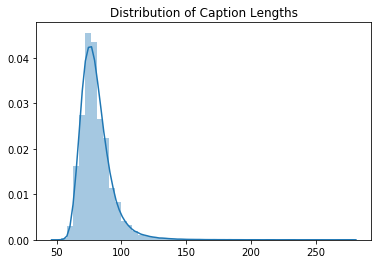

In [20]:
# Understand the distribution of sentence lengths
sentence_lengths = [len(caption) for caption in captions]
plt.title('Distribution of Caption Lengths')
sns.distplot(sentence_lengths)

After preprocessing, I use Global Vectors for Word Representation (GloVe) to obtain embedding vectors for words in the captions. The position of a word within the vector space is learned based on the words that surround the word in the training data, in this case, on the Wikipedia 2014 and Gigaword 5 data (glove.6B.300d.txt). And I supplied the vector weights to be used in the embedding layer of the model.

In [21]:
# Calculates sentence and vocab lengths
# Manually set the maximum sentence length after observing the distribution
max_length = 100  
vocab_size = len(tokenizer.index_word)
print("Original max sentence length is %s; I set it to %s." %
      (calc_max_length(captions), max_length))
print("The vocabulary size is: %s" % (vocab_size))

Original max sentence length is 278; I set it to 100.
The vocabulary size is: 23636


The `glove.6B.300d.txt` file obtaiend at the beginning of the notebook is used here. 

In [22]:
embedding_dim = 300
embeddings_index = {}

with open(data_dir + '/glove6b/glove.6B.%sd.txt' % (embedding_dim),
          encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
# Get dense vector
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in (tokenizer.word_index).items():
    # All 0 is words not found in the embedding index
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(23636, 300)

# Model

The original model framework used here is inspired by various online blog posts and tutorials on similar projects, but the code is largely my own. Some function definitions, such as generate sequence, come from Stack Overflow help articles on word-by-word predictions. The use of Inception-V3 and for image encoding is inspired by the paper "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention."

In [25]:
# Extract features
inputs1 = tf.keras.Input(shape=(2048, ))
fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
# Sequence model
inputs2 = tf.keras.Input(shape=(max_length, ))
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.5)(se1)
se3 = tf.keras.layers.LSTM(256)(se2)
# Decoder model
decoder1 = tf.keras.layers.Add()([fe2, se3])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
# Final model
model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

W0803 18:27:23.827581 140642564364096 deprecation.py:506] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 18:27:23.840424 140642564364096 deprecation.py:506] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 18:27:23.993920 140642564364096 deprecation.py:323] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:

Set weight using the glove embedding matrix

In [26]:
# Add the embedding matrix and set the layer to be not trainable
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

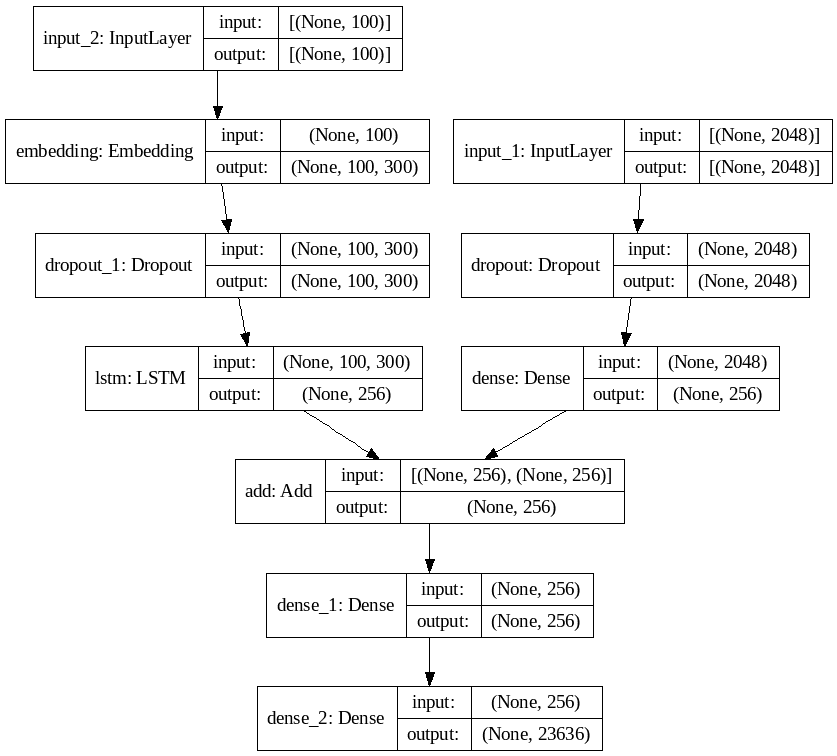

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     7090800     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In this model, input layers from images and captions vectors are passed into the model, dropout layers are applied to the respective inputs, and then the text input is passed through an LSTM layer while the image input through a fully connected layer to ensure the output has the same dimension as the LSTM output. The input tensors are then added together and passed through fully connected layers for next word prediction. To train and predict the caption word-by-word, the model starts by using the current image and the starting tag “start_sentence” to predict the first actual word of the caption. After this iteration, two words are in the input. Based on the “start_sentence” and the last word predicted, the model is then trained to predict the second actual word of the caption. This cycle continues until the model has predicted the “end_sentence” word. I will now explain why dropout layers and LSTM layer are used. 

Dropout layers are used because they can reduce overfitting (regularizing), therefore improving the generalizability of the model. The dropout layer achieves this effect by randomly sample and drop outputs from the image and text input layers. Due to the limited number of images used, I decided to use a dropout layer because the large network used to train the model on this small data set has the potential of over-learning the signals in the images and text, picking up noise as signal as a result. A commonly used dropout value is 0.5, which means each output has 50% of the chance to be retained. I use a dropout value of 0.5. 

After passing the image and text features through the dropout layer respectively, I passed the text input through a Long Short Term Memory (LSTM) layer, and the image feature input through a dense layer, before adding the inputs together. When generating a sentence, creating a sensible prediction of the next word requires an understanding of the word prior to it. Therefore, a recurrent neural network is used when understanding of the prior data is required to produce more accurate prediction. While RNN is not competent at learning long-term dependencies, LSTM model is able to remember information for a long period of time. This is essential to the word-by-word prediction tasks because the last word of a caption might bear strong connection to the first word. For instance, in the sentence “a plane fly through the sky”, the last word “sky” ties back to the second word “a plane”, because the subject is a “plane”, it can only fly through the “sky” rather fly through, say, the “road”. In this case, an understanding of the long-term dependencies is needed to successfully make an accurate prediction of the last word. On the other hand, the image data is passed through a fully connected layer to shrink the image features to the same size as a text input. 

After processing image and text by themselves, the Add layer add the image and text tensors and return a single tensor before passing them through last two fully connected layers for prediction. Based on the input sequence and the image features, the final model predicts the output of the next word. I then append the new word predicted by the model onto the existing list of words, which then serve as the new input sequence to be supplied to the model along with the same image. This prediction cycle repeats until the model has predicted the keyword “end_sentence” to let us know that it believes this is the appropriate place to end the sentence. 

The model is trained on 80,000 image features together with their respective captions. The captions are broken down to sequence of input and output with each segment of the sentence as input. A sequence generator is used to take the first word as input to predict the second word, and then first and second words as input to predict the third word, and so on. The sequence generator is then placed inside the data generator to link the sequence inputs with the image inputs and yield these results to the fit generator of the model. The series of generators make it possible for the model to run through the word-by-word prediction on this large number of image vectors without running into memory issues. 

At the first few epochs, the model exhibits underfitting behavior where no distinct captions are generated, but after around 60 epochs, the model starts to exhibit overfitting behavior where convoluted vocabularies are used to form captions that do not make much sense. While training the model, I spent additional time to evaluate sample output in person rather than relying solely on metrics such as categorical loss and BLEU scores, because sometimes the captions produced by the model with the low loss and high BLEU scores do not always make sense to a human reader, and the appeal to human readers is the best judge of the model performance. 

A wide range of parameters in the model can be tuned. Due to the limited computation resources and methods for tuning due to the use of the fit generator, I tuned the batch size of 500, 1000, 2000, and 3000. The model with a batch size of 500 produced most sensible results overall among the 30 images I sampled. If I have more time, I will also tune the dropout rate, maximum sentence length, word frequency cut-off values (currently none), etc. 


## Training

This function is used to generate a sequence of text as input and output. The generated sequences are then past into data generator and used for caption predictions. The `generate_sequences` function allows the model to perform word-by-word caption generation.

In [30]:
# Generate sentence to break sentence into in and out segments for word-by-word prediction
def generate_sequences(tokenizer, max_length, caption, image_feature):
    Ximages, XSeq, y = list(), list(), list()
    vocab_size = len(tokenizer.word_index)
    seq = tokenizer.texts_to_sequences([caption])[0]
    # Split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # Select substrings
        in_seq, out_seq = seq[:i], seq[i]
        # Pad input sequence
        in_seq = tf.keras.preprocessing.sequence.pad_sequences(
            [in_seq], maxlen=max_length, padding='post')[0]
        # Encode output sequence
        out_seq = tf.keras.utils.to_categorical([out_seq],
                                                num_classes=vocab_size)[0]

        image_feature = np.squeeze(image_feature)
        Ximages.append(image_feature)
        XSeq.append(in_seq)
        y.append(out_seq)
        
    # Connect sentence sequence with images and the output sequence
    Ximages, XSeq, y = np.array(Ximages), np.array(XSeq), np.array(y)
    return [Ximages, XSeq, y]

Create Python data generator object to loop through all images. Use batch size to batch images and their corresponding caption sequences together before `yielding` to the `fit generator`.

In [31]:
# Python data generator object to loop through all images
def data_generator(tokenizer, max_length, captions, images_features, batch_size):
    n = 0
    while True:
        for i in range(len(captions)):
            in_img_vector = []
            in_seq_vector = []
            out_word_vector = []
            # Load image feature
            image_feature = images_features[i]
            # Generate word sequence
            caption = captions[i]
            in_img, in_seq, out_word = generate_sequences(
                tokenizer, max_length, caption, image_feature)
            in_img_vector.append(in_img)
            in_seq_vector.append(in_seq)
            out_word_vector.append(out_word)
            n += 1
            # When batch size is reached, yield the output
            if n == batch_size:
                n = 0
                yield [in_img, in_seq], out_word

In [32]:
# Predict caption
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'start_sentence'
    for i in range(max_length):
        # Use input and image to start predict the rest of the caption
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences(
            [sequence], maxlen=max_length, padding='post')
        photo = photo.reshape(2048, 1).T
        
        # Predict the next word based on sequence and image
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        
        # End prediction when no word is predicted or if ending word is seen
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end_sentence':
            break
    
    # Remove beginning and ending signal words when output
    in_text = re.sub(r'(start|end)_sentence', '', in_text).strip()
    return in_text

In [33]:
# Store default weights in the model directory
model_directory = './model'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model.save_weights(model_directory + '/model.h5')

Reset model weights to default

In [34]:
# Reset model with default weights before training
model.load_weights(model_directory + '/model.h5')

I used a fit generator because it is difficult to store $10,000$ images in the memory.

In [35]:
# Specify final model parameters
# After trying out different batch sizes, chose the one that provided the most reasonable results
epochs = 50
batch_size = 500
steps = len(captions) // batch_size
epoch_idx = 0

In [36]:
# Create dictionary to store loss values. Need this because using fit generator
loss = {}

In [40]:
# Use fit generator due to limited memory.
while epoch_idx <= epochs:
    # Use data generator to input data
    generator = data_generator(tokenizer, max_length, captions,
                               images_features, batch_size)
    # Fit generator is used due to memory limitation
    history = model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
    loss[epoch_idx] = history.history['loss']
    model.save_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epoch_idx, batch_size))

    epoch_idx += 1

    # Keep track of the number of distinct captions
    distinct_desc = []
    temp_desc = ''
    for j in range(20):
        img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
        distinct_desc.append(img_desc)
        temp_desc += '' + img_desc

    print("Model %s generated %s distinct captions with %s distinct words." %
          (epoch_idx, len(list(set(distinct_desc))), len(list(set(temp_desc.split(' '))))))

800/800 [==============================] - 237s 296ms/step - loss: 5.7045
Model 1 generated 17 distinct captions with 6 distinct words.
800/800 [==============================] - 235s 293ms/step - loss: 4.4538
Model 2 generated 8 distinct captions with 8 distinct words.
800/800 [==============================] - 235s 294ms/step - loss: 4.1143
Model 3 generated 6 distinct captions with 10 distinct words.
800/800 [==============================] - 235s 293ms/step - loss: 3.8695
Model 4 generated 12 distinct captions with 16 distinct words.
800/800 [==============================] - 236s 295ms/step - loss: 3.5979
Model 5 generated 7 distinct captions with 17 distinct words.
800/800 [==============================] - 236s 295ms/step - loss: 3.3937
Model 6 generated 13 distinct captions with 27 distinct words.
800/800 [==============================] - 235s 293ms/step - loss: 3.1607
Model 7 generated 17 distinct captions with 33 distinct words.
800/800 [==============================] - 236

At the first few epochs of the model training process, the model exhibits underfitting behavior where no distinct captions are generated. By understanding the number of distinct captions generated for a list of 20 images, I seek to approximate the appeal the model has for a human reader. In addition, as a model continues to learn from the training data, it becomes capable of generating more vocabularies as well.

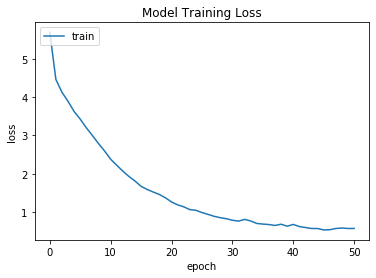

In [41]:
# Return the loss plot
plt.title('Model Training Loss')

loss_lists = sorted(loss.items())
x, y = zip(*loss_lists)
plt.plot(x, y)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Here are some examples of the output from the model trained with a batch size of 500 after 50 epochs. 

Sample prediction of the model with a batch size of 500 and 50 epochs.

Predicted Caption: two donuts rest alongside an ice tea on a couch 
Actual Caption:  A bright blue plate has a delicious breakfast on it. 
Resulting BLEU-4 score is 1.3693254307640693e-231


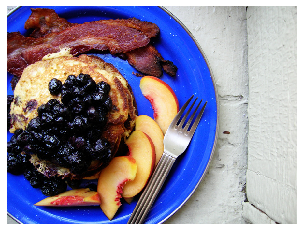

Predicted Caption: a boy riding on a skateboard on the street 
Actual Caption:  A young girl, barley taller than a fire hydrant, stands next to a fire hydrant on the sidewalk of the city street. 
Resulting BLEU-4 score is 1.408376648685561e-231


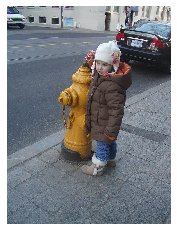

Predicted Caption: an empty bathroom with white fixtures and blue walls 
Actual Caption:  A bathroom is seen with towels on the floor. 
Resulting BLEU-4 score is 1.3351507449681826e-231


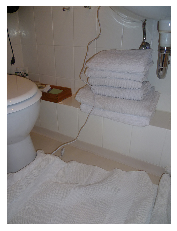

Predicted Caption: many skateboarders going down a very wide city street 
Actual Caption:  There is a white train passing a factory 
Resulting BLEU-4 score is 1.2821097245439388e-231


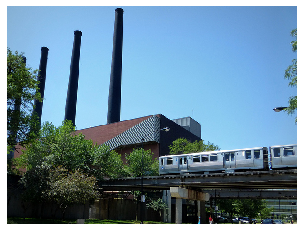

Predicted Caption: several large elephants standing in a mud field 
Actual Caption:  An man is riding an elephant on the walkway. 
Resulting BLEU-4 score is 1.3459095292012048e-231


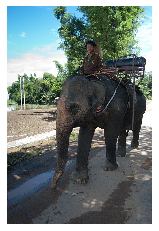

In [40]:
# Train images
print(
    "Sample prediction of the model with a batch size of %s and %s epochs.\n" %
    (batch_size, epochs))

# Load the latest model weight
model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                   (epochs, batch_size))

# Output prediction for the first five images in the validation data. 
# Note that the data set is already shuffled.
np.random.seed(47)
for j in np.random.choice(range(len(test_captions)), 5):
    # Compare captions
    img_desc = generate_desc(model, tokenizer, test_images_features[j],
                             max_length)
    actual_caption = test_captions[j]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)

    print("Predicted Caption: %s \nActual Caption: %s" %
          (img_desc, actual_caption))
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s" % (result_bleu))
    # Show image
    I = io.imread(test_images[j])
    plt.imshow(I)
    plt.axis('off')
    plt.show()

## Tuning

A wide range of parameters in the model can be tuned. Due to the limited computation resources and methods for tuning with fit generator, I tuned the batch size. If I have more time, I will also tune the drop out rate, maximum sentence length, word frequency cut-off values (currently none), etc.

In [154]:
# Trying out different batch sizes
for batch_size in [500, 1000, 2000, 3000]:
    loss = {}
    model.load_weights(model_directory + '/model.h5')
    steps = len(captions) // batch_size
    print(batch_size)
    epoch_idx = 0
    while epoch_idx <= epochs:
        generator = data_generator(tokenizer, max_length, captions,
                                   images_features, batch_size)
        history = model.fit_generator(generator,
                                      steps_per_epoch=steps,
                                      verbose=1)
        loss[epoch_idx] = history.history['loss']

        model.save_weights(model_directory + '/model_epoch' + str(epoch_idx) +
                           "_bs" + str(batch_size) + '.h5')
        epoch_idx += 1

        distinct_desc = []
        temp_desc = ''
        for j in range(20):
            img_desc = generate_desc(model, tokenizer, images_features[j],
                                     max_length)
            distinct_desc.append(img_desc)
            temp_desc += '' + img_desc

        print("%s distinct captions, %s distinct words." % (len(
            list(set(distinct_desc))), len(list(set(temp_desc.split(' '))))))

    # Plot model loss
    plt.title('Model Training Loss')

    loss_lists = sorted(
        loss.items())  # sorted by key, return a list of tuples
    x, y = zip(*loss_lists)  # unpack a list of pairs into two tuples
    plt.plot(x, y)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

500
  8/800 [..............................] - ETA: 4:10 - loss: 8.8656

KeyboardInterrupt: 

Now, we turn to test the performance of the models trained using different batch sizes using the same train and validation images.

### Test on Training Data

In [56]:
np.random.seed(17)

In [57]:
rand_train_image = np.random.choice(range(len(captions)))

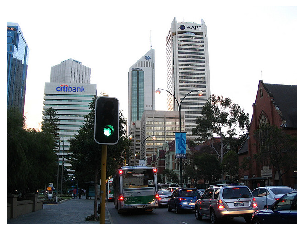

The actual caption is:
there are many tall buildings and cars in this city. 

The predicted captions are:
Batch size = 500: a tall glass building with a street sign on the street
Resulting BLEU-4 score is 1.299995630345669e-231

Batch size = 1000: a police motorcycle driving along a street with flags flying from his vehicle
Resulting BLEU-4 score is 1.2103429839337648e-231

Batch size = 2000: a somewhat dark view of a train pulling several cars
Resulting BLEU-4 score is 1.3351507449681826e-231

Batch size = 3000: a parking meter sits by a brick wall
Resulting BLEU-4 score is 1.4386816597928502e-231



In [58]:
I = io.imread(images[rand_train_image])
plt.imshow(I)
plt.axis('off')
plt.show()

# Obtain actual and predicted images and their captions
actual_caption = captions[rand_train_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:" %
      (actual_caption))

for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer,
                             images_features[rand_train_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s" % (bs, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s\n" % (result_bleu))

### Test on Validation Data

In [59]:
np.random.seed(511)

In [60]:
rand_test_image = np.random.choice(range(len(test_captions)))

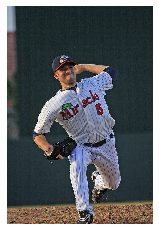

The actual caption is:
the professional baseball player is pitching a baseball. 

The predicted captions are:
Batch size = 500: a baseball team and spectators during a baseball game
Resulting BLEU-4 score is 1.3060847694489178e-231

Batch size = 1000: a close up of a batter holding a baseball game
Resulting BLEU-4 score is 1.3991003373328715e-231

Batch size = 2000: a baseball team and spectators during a baseball game
Resulting BLEU-4 score is 1.3060847694489178e-231

Batch size = 3000: a baseball team and spectators during a baseball game
Resulting BLEU-4 score is 1.3060847694489178e-231



In [61]:
I = io.imread(images[rand_test_image])
plt.imshow(I)
plt.axis('off')
plt.show()

# Obtain actual and predicted images and their captions
actual_caption = captions[rand_test_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:" %
      (actual_caption))

for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer,
                             images_features[rand_test_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s" % (bs, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s\n" % (result_bleu))

# Discussion

In [64]:
# Understand vocab distribution to showcase the model bias
# Note that identifying stop words and lemmatization takes a while.
word_list = []
for caption in captions:
    seq = caption.split(" ")
    word_list += seq

# Remove idiosyncracies in word usage
lemmatizer = WordNetLemmatizer()
word_list = [
    lemmatizer.lemmatize(word.lower()) for word in word_list
    if word and word.lower() not in nltk.corpus.stopwords.words('english')
    and "_" not in word
]

# Calculate frequency distribution
word_list_dist = nltk.FreqDist(word_list)

In [125]:
# Run this line to output most frequently used vocabularies in the data set
limit = 30
word_dict = dict()
for word, frequency in word_list_dist.most_common(limit):
    print(u'{}\t\t{}'.format(word, frequency))
    word_dict[word] = frequency

man		48873
sitting		35724
two		32401
standing		28438
people		27452
woman		26082
next		24997
white		24120
holding		18867
person		16538
large		16373
group		14706
table		14381
street		14087
top		14033
small		13505
near		13348
dog		12860
black		12830
front		12738
tennis		12625
train		12476
riding		12367
cat		12152
young		11503
red		11303
plate		11252
sign		10467
playing		9817
baseball		9750


## Learning
Image captioning requires implementation of deep learning methods in both computer vision and natural language processing. While doing this project, I learned to use transfer learning by using image and word embeddings. Drop-out layers are included to prevent the model from overfitting, and model tuning is performed to ensure the model achieve reasonable performance.

Model tuning helps identify that the model tends to perform better with the batch size of 500 among the list of the values tested. Increasing the number of epochs is shown to help the model generate more complex vocabularies but doing that also cause the model to overfit easily. The final model is able to produce sensible captions for the images supplied. However, there remains potential for improvements.

## Areas of Improvement

The model is able to provide reasonable captions given the images supplied, but the model appears to have difficulty distinguishing objects with similar property, and the model also has a bias towards objects and captions that appear more often in the data set. Last but not the least, a better metric should be used to systematically measure model performance.

The model seems to have trouble distinguishing between objects that have subtle differences, such as sky and ocean, snowboards and surf board, etc. For instance, the model mistakes a man performing a snowboard jump as someone surfing in the ocean, presumably because the blue sky in the background bears resemblance to the color ocean, and the skis appearing in the image looks similar to a surf board. Data augmentation using data generators may help model better distinguish similar objects.

Furthermore, there appear to be bias in captioning due to the class imbalance in the training data set. When describing people in images, the model is more likely to predict a person as a “man” or a "guy" even when the subject is in fact a woman. This is likely caused by the nature of the original training images and captions. As an evidence, in the “Word Distribution” section, you will notice that the “man” is the most popular word used after removing stop words, while women is ranked 5th, showing that male images occur more often than female's. Here is the short list of words with their respective frequencies in the data set together with an example of the prediction that shows the model's gender bias.


```
man        48873
sitting    35724
two        32401
standing   28438
people     27452
woman      26082
```

In this example, the model confuses man and woman. As shown in the list above, "man" is the more popular word.

In [63]:
def show_img_example(img_idx):
    # Show images given index
    I = io.imread(images[img_idx])
    plt.imshow(I)
    plt.axis('off')
    plt.show()

    # Create actual and predicted caption
    actual_caption = captions[img_idx]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()

    model.load_weights(model_directory + '/model_epoch50_bs500.h5')
    img_desc = generate_desc(model, tokenizer, images_features[img_idx],
                             max_length)

    print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s" %
          (actual_caption, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("\nResulting BLEU-4 score is %s\n" % (result_bleu))

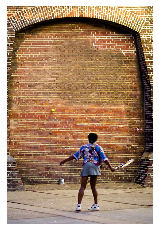

The actual caption is:
a young girl is playing ball on a brick wall. 

The predicted captions is:
a guy lost their skateboard when trying to do a trick on the beach

Resulting BLEU-4 score is 1.2578972116573994e-231



In [150]:
show_img_example(9836)

One future improvement is to up-sample the female images and captions in the data set to improve the model's ability to recognize female. In addition, in the process of image labeling, the generic use of “man” when both genders appear should be avoided to help model better understand the gender differences.

The categorical loss measure for model accuracy is not a good measure of the model performance. While the model performance improves with categorical accuracy, at a low loss value, the model has tendency of overfitting, producing vocabularies that do not fit well together as a sentence. The categorical loss fails to account for the readability of the content. I have tested out the use of BLEU score to measure caption similarity to the original caption, but BLEU score fails to account for the semantic similarity of the predicted caption and actual caption. In addition, due to the difficulty with the caption learning task in itself, the scale BLEU score provides fails to provide meaningful comparison across models. For instance, one might argue that the predicted caption “a baby giraffe eating leaves on a meadow” is a good approximation of the original one “A giraffe that is eating some leaves off of a tree”. However, a BLEU score of $1.39e^{-231}$ is given in this case.

In [151]:
result_bleu = nltk.translate.bleu_score.sentence_bleu(
    "A giraffe that is eating some leaves off of a tree.",
    "a baby giraffe eating leaves on a meadow ")
print("Resulting BLEU-4 score is %s" % (result_bleu))

Resulting BLEU-4 score is 1.3926576473519284e-231


Lastly, I was unable to identify a way to perform grid search for hyperparameter tuning when fit_generator is used. In addition, my computation resource is limited. Therefore, I used a for loops for testing the model with different batch sizes. If time and resource permit, I will also tune dropout rate, maximum sentence length, word frequency cut-off values (currently none), etc.

-----

Random image generator to help me find examples:

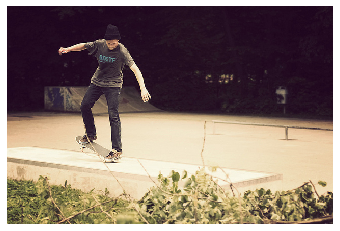

The actual caption is:
a skateboarder is riding on a plank in the dirt. 

The predicted captions is:
a man and a girl doing on a skateboard in the street

Resulting BLEU-4 score is 1.3351507449681826e-231

75799


In [238]:
img_idx = np.random.choice(range(len(test_captions)))
show_img_example(img_idx)
print(img_idx)

----

Link to Youtube Video: https://youtu.be/_IFIf4Gn4i0